# Advanced Lane Finding Project (TestImage Pipeline Part2)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## TestImage Pipeline ##

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread

from scipy.ndimage.interpolation import rotate

import platform

%matplotlib inline


## load saved pickle camera calibration parameters ##

In [3]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


## test loaded mtx dist is successfully working to get it done ##

In [38]:
# read chess board images 
imagefiles = glob.glob('./camera_cal/calibration*.jpg')
print(imagefiles)

['./camera_cal/calibration5.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration8.jpg']


In [10]:
test_image = imread('./camera_cal/calibration13.jpg')
nx = 9
ny = 6

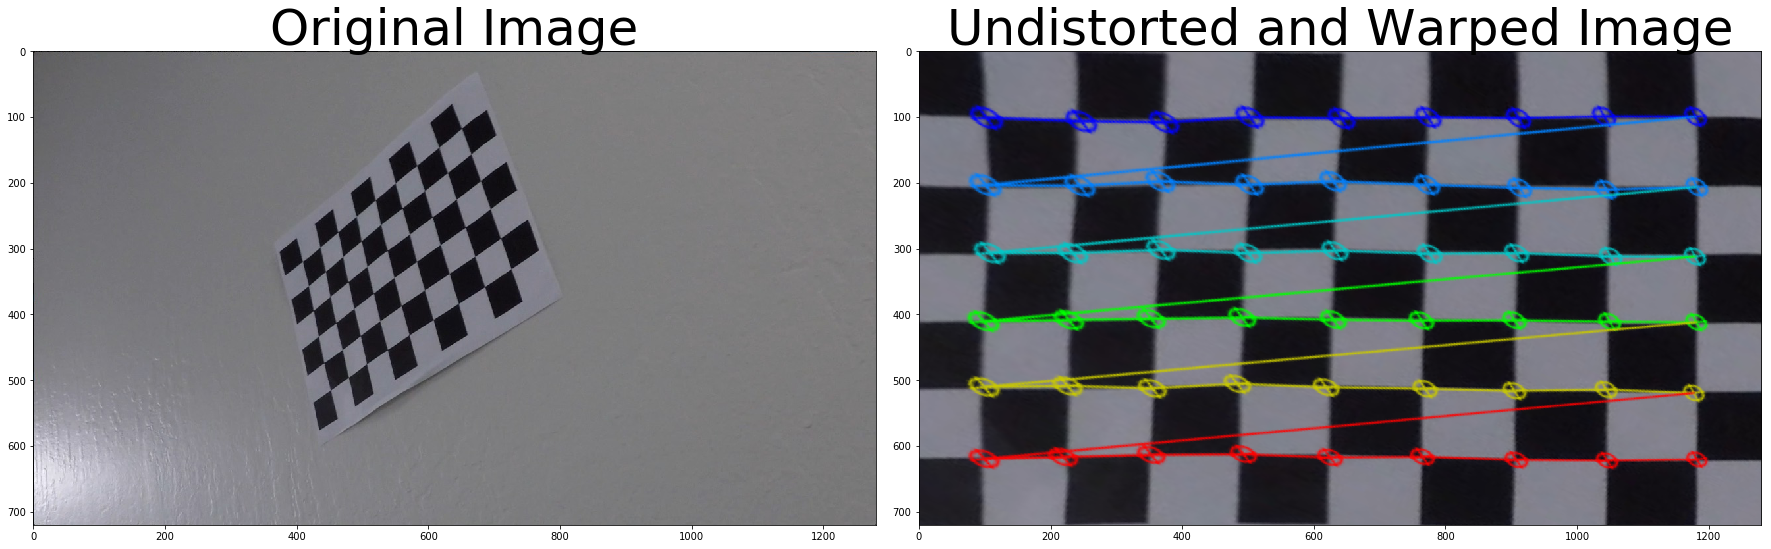

In [16]:
top_down, perspective_M = corners_unwarp(test_image, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
def corners_unwarp(img, nx, ny, mtx, dist):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


## review onward project steps ## 
---

*    Camera calibration
*    Distortion correction
*    Color/gradient threshold
*    Perspective transform


In [19]:
test_image1 = imread("./test_images/test1.jpg")

## Test Images ##

***

* test1 image is slightly cut from bottom line when applying cv2.undistort 

------------------------------


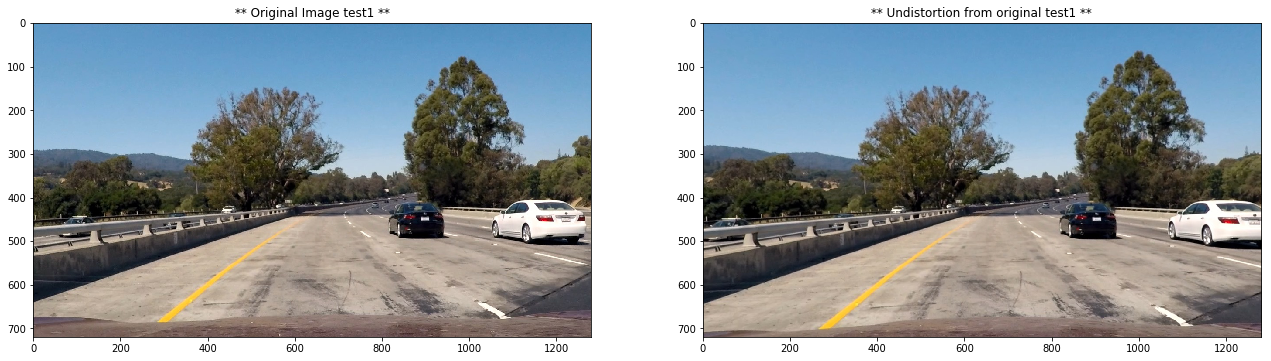

In [23]:
plt.figure(figsize=(22,10))  
plt.subplot(1,2,1  )
plt.title("** Original Image test1 **")
plt.imshow(test_image1)

plt.subplot(1,2,2  )

undist = cv2.undistort(test_image1, mtx, dist, None, mtx)
plt.title("** Undistortion from original test1 **")
plt.imshow(undist)
print("-"*30)        

### common function to set threshhold values ###

In [29]:
def threshold(img, thresh_min=0, thresh_max=255):
    # 
    # Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    # 
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    
    return xbinary
    

## Finding Lanes (Sobel technique) ##

In [81]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0    
    
    # Apply the following steps to img
    # 1) Convert to grayscale (RGB -> GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, xorder, yorder)
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8( 255 * sobel / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = threshold(sobel,thresh_min,thresh_max)
    #sxbinary = np.zeros_like(sobel)
    #sxbinary[(sobel >= thresh_min) & (sobel <= thresh_max)] = 1
    return sxbinary
    
    # Run the function
    #grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    # Plot the result

In [86]:
sobel_image = abs_sobel_thresh(test_image1, orient='y', thresh_min=30, thresh_max=200)

#### Lane identification by Sobel filter ####
* hard to see which line is lane...

------------------------------


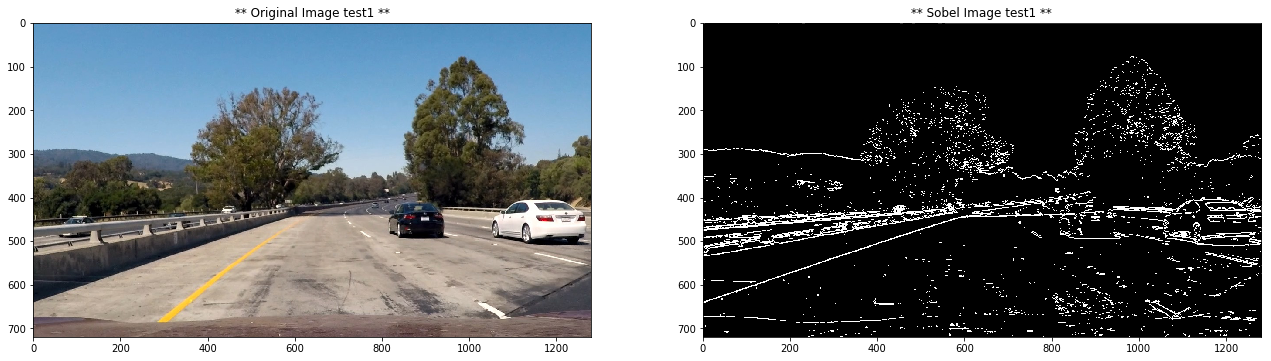

In [87]:
plt.figure(figsize=(22,10))  
plt.subplot(1,2,1  )
plt.title("** Original Image test1 **")
plt.imshow(test_image1)

plt.subplot(1,2,2  )

#undist = cv2.undistort(test_image1, mtx, dist, None, mtx)
plt.title("** Sobel Image test1 **")
plt.imshow(sobel_image, cmap="gray")
print("-"*30)   

In [37]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # vertical and holizontal gradient 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    # magunitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel = np.sqrt( abs_sobelx **2 + abs_sobely ** 2  )
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8( 255 * sobel / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    
    sxbinary = threshold(sobel,mag_thresh[0],mag_thresh[1])
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary
    
    # Run the function
    #mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    # Plot the result

#### Lane identification by Sobel Magunitude filter ####
* slightly better than simple sobel technique

In [55]:
mag_binary = mag_thresh(test_image1, sobel_kernel=3, mag_thresh=(50, 200))

------------------------------


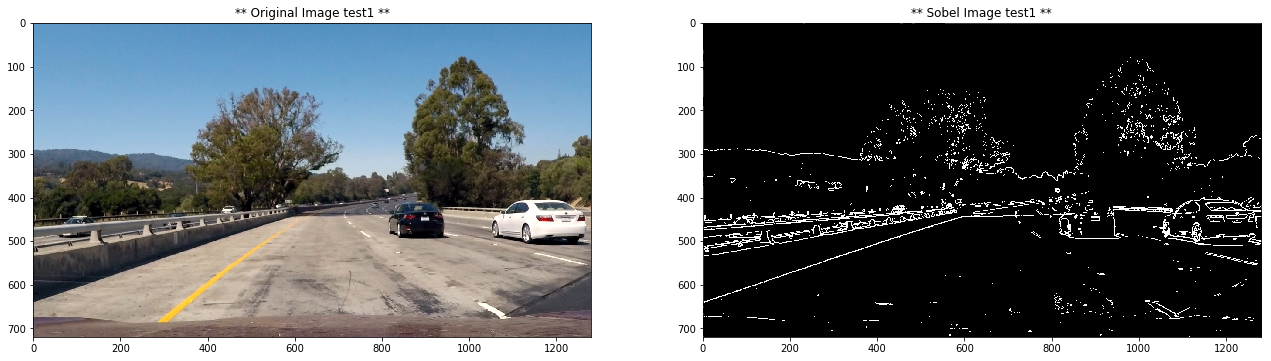

In [56]:
plt.figure(figsize=(22,10))  
plt.subplot(1,2,1  )
plt.title("** Original Image test1 **")
plt.imshow(test_image1)

plt.subplot(1,2,2  )

#undist = cv2.undistort(test_image1, mtx, dist, None, mtx)
plt.title("** Sobel Image test1 **")
plt.imshow(mag_binary, cmap="gray")
print("-"*30)   

#### Lane identification by Direction of Gradient filter ####
* lane is displayed as white line, but it does not fit the line..

In [57]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    # magunitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    #sobel = np.uint8( 255 * sobel / np.max(sobel))
    #print(sobel)
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(sobel)
    sxybinary[(sobel > thresh[0]) & (sobel < thresh[1])] = 1
    
    
    
    
    
    #binary_output = np.copy(img) # Remove this line
    return sxybinary
    

In [58]:
dir_binary = dir_threshold(test_image1, sobel_kernel=15, thresh=(0.7, 1.3))

------------------------------


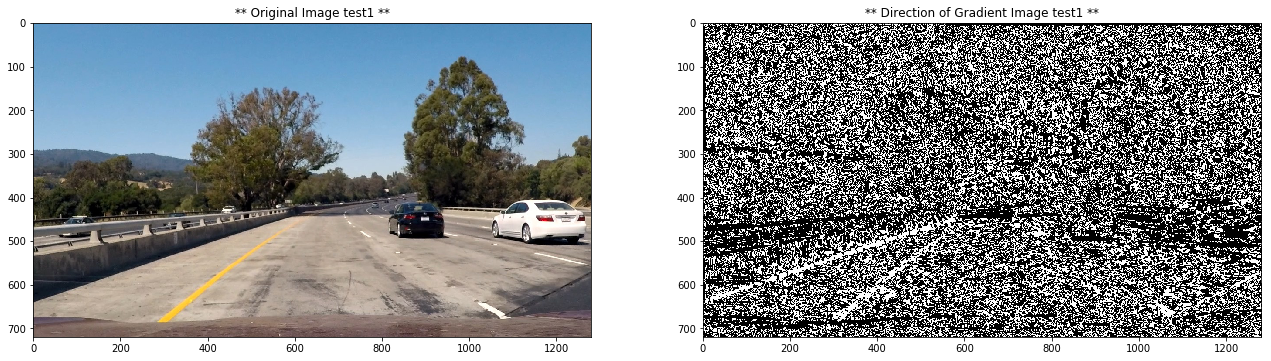

In [59]:
plt.figure(figsize=(22,10))  
plt.subplot(1,2,1  )
plt.title("** Original Image test1 **")
plt.imshow(test_image1)

plt.subplot(1,2,2  )

#undist = cv2.undistort(test_image1, mtx, dist, None, mtx)
plt.title("** Direction of Gradient Image test1 **")
plt.imshow(dir_binary, cmap="gray")
print("-"*30)   

In [103]:
ksize=3
sobel_imagex = abs_sobel_thresh(test_image1, orient='x', thresh_min=50, thresh_max=225)
sobel_imagey = abs_sobel_thresh(test_image1, orient='y', thresh_min=50, thresh_max=225)
mag_binary = mag_thresh(test_image1, sobel_kernel=ksize, mag_thresh=(30, 255))
dir_binary = dir_threshold(test_image1, sobel_kernel=ksize, thresh=(0.7, 1.3))


In [111]:
mybinary = np.zeros_like(dir_binary)
#mybinary[ ((sobel_imagex == 1) & (sobel_imagey == 1)) | ( (mag_binary == 1) & (dir_binary == 1)      )      ] = 1
mybinary[ (mag_binary == 1) & (dir_binary == 1)            ] = 1
    

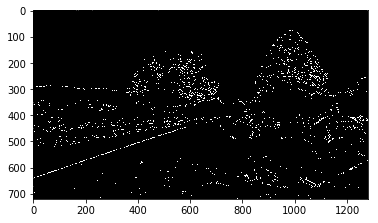

In [112]:
plt.imshow(mybinary, cmap="gray")